In [8]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Importing the csv files. One for training data and one for testing data.
train = pd.read_csv('trainhouse.csv')
test = pd.read_csv('testhouse.csv')


# 1. Reading the data:

In [10]:
# Viewing the train data. I can already see there are a few missing values.
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [11]:
# Moving the train without the Saleprice column.
X = pd.DataFrame(train.loc[:, train.columns != 'SalePrice'])
# Here I am using concat to add the testing data to the train data.
X = pd.concat([X, test], axis=0)
# Creating the Y for train test split.
y = pd.DataFrame(train['SalePrice'])


In [12]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

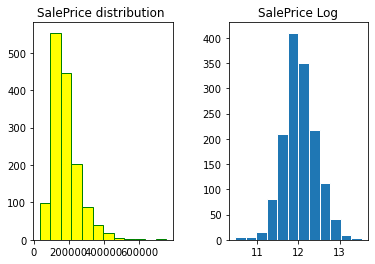

In [13]:
# Creating a bar graph to view how the SalePrice data is distributed.  
fig, ax = plt.subplots(1,2)
# The graph has a long right tail which means it is right skewed.
ax[0].hist(train['SalePrice'], bins=12, edgecolor='green', facecolor='yellow');
ax[0].set_title("SalePrice distribution ")
# Log of the SalePrice.
ax[1].hist(np.log(y['SalePrice']),bins=12,edgecolor='white')
ax[1].set_title('SalePrice Log')
plt.subplots_adjust(right=0.9, wspace=0.4, hspace=0.4)


<AxesSubplot:>

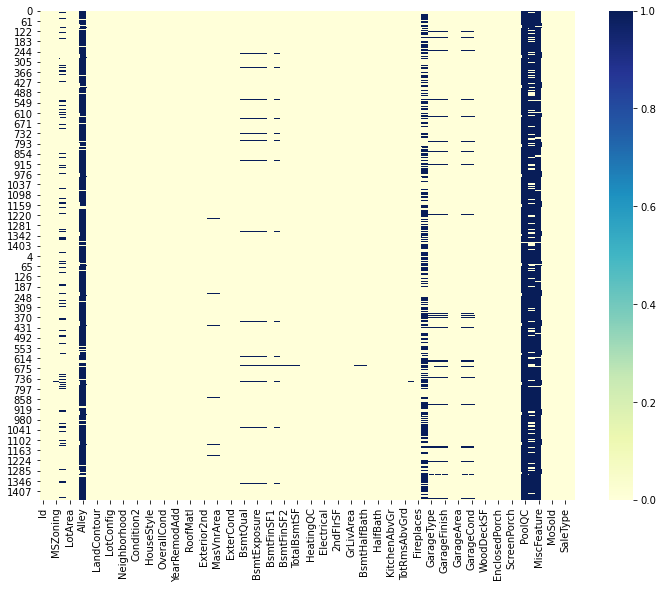

In [14]:
# Heatmap to visualize the missing data using seaborn.
plt.figure(figsize=(12, 9))
sns.heatmap(X.isnull(),cmap='YlGnBu')
# The blue represents any missing values.

In [15]:
# As you can see there is a lot of missisng data in this dataset. 
X.isnull().sum().sum()

13965

# 2. Data Cleaning:

In [16]:
# Filling in the null values.
X['Functional'].fillna('Typ', inplace=True)
X['Electrical'].fillna('SBrkr', inplace=True)

# Filling in these features with "No", which means they do not have this feature.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MiscFeature', 'Fence', 'FireplaceQu', 'Alley', 'PoolQC'):
  X[col] = X[col].fillna('No')

# Filling these features with zeros
for col in ('GarageArea', 'GarageCars'):
  X[col] = X[col].fillna(0)

# Filling these features with the mode.
for col in ('MSZoning', 'Utilities', 'MasVnrType', 'Exterior1st', 'Exterior2nd', 'SaleType'):
  X[col] = X[col].fillna(X[col].mode()[0])

# The rest of the data I am filling in with the median
X.fillna(X.median(), inplace=True)

# 3. Feature Engineering:

In [17]:
# Adding new features to the dataset by using the original features
X['AllSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['BackyardSF'] = X['LotArea'] - X['1stFlrSF']
X['PorchSF'] = X['WoodDeckSF'] + X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch'] 
X['Total_Bathrooms'] = X['FullBath'] + X['BsmtFullBath'] + (.5 * X['HalfBath']) + (.5 * X['BsmtHalfBath'])
X['MedNhbdArea'] = X.groupby('Neighborhood')['GrLivArea'].transform('median')
X['IsAbvGr'] = X[['MedNhbdArea', 'GrLivArea']].apply(lambda x: 'yes' if x['GrLivArea'] > x['MedNhbdArea'] else 'no', axis=1)


<AxesSubplot:>

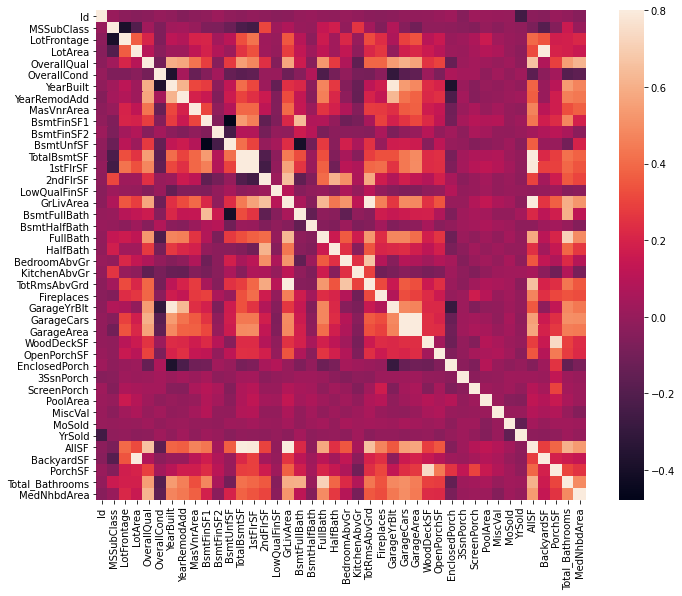

In [18]:
# Correlation matrix
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)


# 4. Scaling, Encoding, Transforming:

In [19]:
scale = ['MedNhbdArea', 'BackyardSF', 'PorchSF', 'WoodDeckSF', 'OpenPorchSF','AllSF', '1stFlrSF','2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF','GarageArea','GrLivArea','LotArea','LotFrontage','LowQualFinSF','MasVnrArea','TotalBsmtSF','PoolArea']

encode = list(set(X.columns) - set(scale) - set(['Id']))

# Working with the skew
skew_feats = X[scale].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats.astype('float')})
skewness = skewness[(skewness.Skew > .75)]
indeces = list(skewness.index)

# Why an I using log: It helps improve the skew of the data.
for x in indeces:
  X[x] = np.log1p(X[x])


In [20]:
# Starting to scale: Transforming by calculating the distances between the data.
Xscale = X[scale]
scaler = MinMaxScaler().fit(Xscale)
Xscale = pd.DataFrame(scaler.transform(Xscale), columns=Xscale.columns)

# Encoding the data
Xencode = X[encode]

# Merge the encoding with the scale data and reset the index.
X = Xscale.merge(Xencode.reset_index(), left_index=True, right_index=True)
# Turning the data into dummies.
X = pd.DataFrame(pd.get_dummies(data=X))

# Working with OrdinalEncoder and then reshaping
oc = OrdinalEncoder()
for x in X:
  if X[x].dtype == 'object':
    X[x] = oc.fit_transform(X[x].values.reshape(-1, 1))
X.head(5)

,MedNhbdArea,BackyardSF,PorchSF,WoodDeckSF,OpenPorchSF,AllSF,1stFlrSF,2ndFlrSF,BsmtFinSF1,BsmtFinSF2,...,BsmtFinType1_No,BsmtFinType1_Rec,BsmtFinType1_Unf,CentralAir_N,CentralAir_Y,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA
0,0.429416,0.411730,0.568325,0.000000,0.624312,0.572376,0.345070,0.884420,0.759508,0.0,...,0,0,0,0,1,1,0,0,0,0
1,0.581196,0.428215,0.784977,0.784977,0.000000,0.567740,0.487537,0.000000,0.797188,0.0,...,0,0,0,0,1,1,0,0,0,0
2,0.429416,0.466002,0.517934,0.000000,0.568957,0.587303,0.371528,0.886245,0.716357,0.0,...,0,0,0,0,1,1,0,0,0,0
3,0.539281,0.433447,0.789060,0.000000,0.542079,0.562004,0.387529,0.868471,0.622780,0.0,...,0,0,0,0,1,0,0,1,0,0
4,1.000000,0.508107,0.774452,0.724696,0.672040,0.646702,0.451824,0.911832,0.750841,0.0,...,0,0,0,0,1,1,0,0,0,0


# 5. Train Test split: 

In [21]:
# Preparing the data for train test split
j = X
length = test.shape[0]
X = j[:train.shape[0]]
test = j[train.shape[0]:test.shape[0]+(length+1)]

# Split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.3, random_state=0)

# Working with ytrain
ytrain = pd.DataFrame(np.log1p(ytrain.SalePrice))
ytrain.reset_index(inplace=True)
ytrain.drop(columns='index', inplace=True)
ytest = pd.DataFrame(np.log1p(ytest.SalePrice))
# Working with ytest
ytest.reset_index(inplace=True)
ytest.drop(columns='index', inplace=True)

# 6. XGBoost:
A few of the more important parameters that are worth nothing:
1. learning_rate: To prevent any over fitting of the data.
2. n_estimators: Value from the parameter tuning.
3. gamma: To not have any regularization. The higher the number the higher the regularization.
4. objective: Using Linear Regression with this XGBoost
5. nthread: The default is -1.
6. reg_alpha: Reduces overfitting and test error.

In [22]:
model = XGBRegressor(learning_rate=0.01, n_estimators=3460, gamma=0, objective='reg:linear', nthread=-1, reg_alpha=0.00006)


In [23]:
#Fitting thr model
preds = model.fit(xtrain, ytrain)
# Predicting the model
preds = model.predict(xtest)
# Finding the mean squared error and removing the log so we can see the number without the log.
np.sqrt(mean_squared_error(np.expm1(ytest), preds))


[03:04:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


199500.53986382837

In [24]:
# Adding log to y
y = pd.DataFrame(np.log1p(y.SalePrice))
# Resetting the index
y.reset_index(inplace=True)
# Dropping the index column
y.drop(columns='index', inplace=True)

In [25]:
# Predicting the final model with test data
final_preds = model.predict(test)
# Removing the log
final_preds = np.expm1(final_preds)
# Adding in the test data from beginning
new_test = test = pd.read_csv('testhouse.csv')


# 7. Submission:


In [26]:
# Working on the final submission.
submission = pd.DataFrame(new_test['Id'], columns=['Id'])
# Adding column for SalePrice
submission['SalePrice'] = final_preds
# Final view of the finished submission data
submission

,Id,SalePrice
0,1461,124183.742188
1,1462,177520.718750
2,1463,193762.875000
3,1464,186515.562500
4,1465,171234.750000
...,...,...
1454,2915,77441.929688
1455,2916,79847.062500
1456,2917,152042.937500
1457,2918,98199.187500


In [27]:
#Saving the submission in order to submit it to Kaggle.
submission.to_csv('submission.csv', index=False, header=True)